In [1]:
import extract_and_transform as et
from sklearn.metrics import mean_squared_error,mean_absolute_error
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
import os
import joblib
import pandas as pd



X_train,X_test,y_train,y_test,real_df,X,y=et.training_data()



scaler=StandardScaler()
scaler.fit(X_train)
X_train_scaled=scaler.transform(X_train)
X_test_scaled=scaler.transform(X_test)



feature_names=["cement","blast_furnace_slage","fly_ash","water","superplasticizer","coarse_aggregate","fine_aggregate","age"]

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
import numpy as np

max_depth = [45]#[int(x) for x in np.linspace(1,201,10)]
max_depth.append(None)
param_grid={'bootstrap':[False],
            'max_depth':max_depth,
            'max_features':['auto','log2'],
            'n_estimators': [156]}#[int(x) for x in np.linspace(1, 201, 10)] }

rfr=RandomForestRegressor(random_state=1)

g_search=GridSearchCV(estimator=rfr,param_grid=param_grid,cv=5,n_jobs=1,verbose=0,return_train_score=True)

g_search.fit(X_train,y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=1), n_jobs=1,
             param_grid={'bootstrap': [False], 'max_depth': [45, None],
                         'max_features': ['auto', 'log2'],
                         'n_estimators': [156]},
             return_train_score=True)

In [ ]:
best_params_dict=g_search.best_params_
best_params_dict

In [ ]:
best_params_df=pd.DataFrame([best_params_dict],index=['Best Parameters']).T
best_params_df

In [ ]:
best_params_df.to_csv('Resources/best_params.csv')

predictions=g_search.predict(X_test)
mse_rf=mean_squared_error(y_test,predictions)
mae_rf=mean_absolute_error(y_test,predictions)
stats={'MSE':mse_rf.round(2),'MAE': mae_rf.round(2),'r_score':(g_search.score(X_test,y_test)).round(2)}
stats

In [ ]:
stats_df=pd.DataFrame([stats],index=['Forest Stats']).T
stats_df

In [ ]:
stats_df.to_csv('Resources/rfr_stats.csv')


feature_imp=pd.Series(g_search.best_estimator_.feature_importances_,index=feature_names).sort_values()

best_features=pd.DataFrame([(feature_imp.round(2)*100).round(2).to_dict()],index=['Best Features']).T
best_features

In [ ]:
best_features.to_csv('Resources/best_features.csv')

def print_predict(y_test,predictions):
    for i in range(len(predictions)):
        act=y_test[i]
        pred=round(predictions[i],2)
        delta=round(act-pred,2)
        print(f"Actual: {act}, Prediction: {pred}, Delta: {delta}")




print_predict(y_test,predictions)

# save
joblib.dump(g_search, "random_forest_regression.joblib")

# load, no need to initialize the loaded_rf
rfr_model = joblib.load("random_forest_regression.joblib")



# from sklearn.model_selection import RandomizedSearchCV
# import numpy as np

# n_estimators = [int(x) for x in np.linspace(5 , 150, 145)] 

# max_depth = [int(x) for x in np.linspace(1,200,200)]
# max_depth.append(None)

# max_depth

# bootstrap=[True,False]

# random_grid={'n_estimators':n_estimators,'max_features':['auto','log2'],'max_depth':max_depth,'bootstrap':bootstrap}

# print(random_grid)

# random_search=RandomizedSearchCV(estimator=rfr,
#                                  param_distributions=random_grid,
#                                  n_iter=50,scoring='neg_mean_absolute_error',
#                                 cv=3,verbose=0,random_state=42,
#                                  n_jobs=1,return_train_score=True)

# random_search.fit(X_train,y_train)

# random_search.best_params_

# random_search.score(X_test,y_test)

# print_predict(y_test,random_search.predict(X_test))

In [ ]:
rfr_model.score(X_test,y_test)

C:\Users\Silho\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Silho\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Silho\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-lev

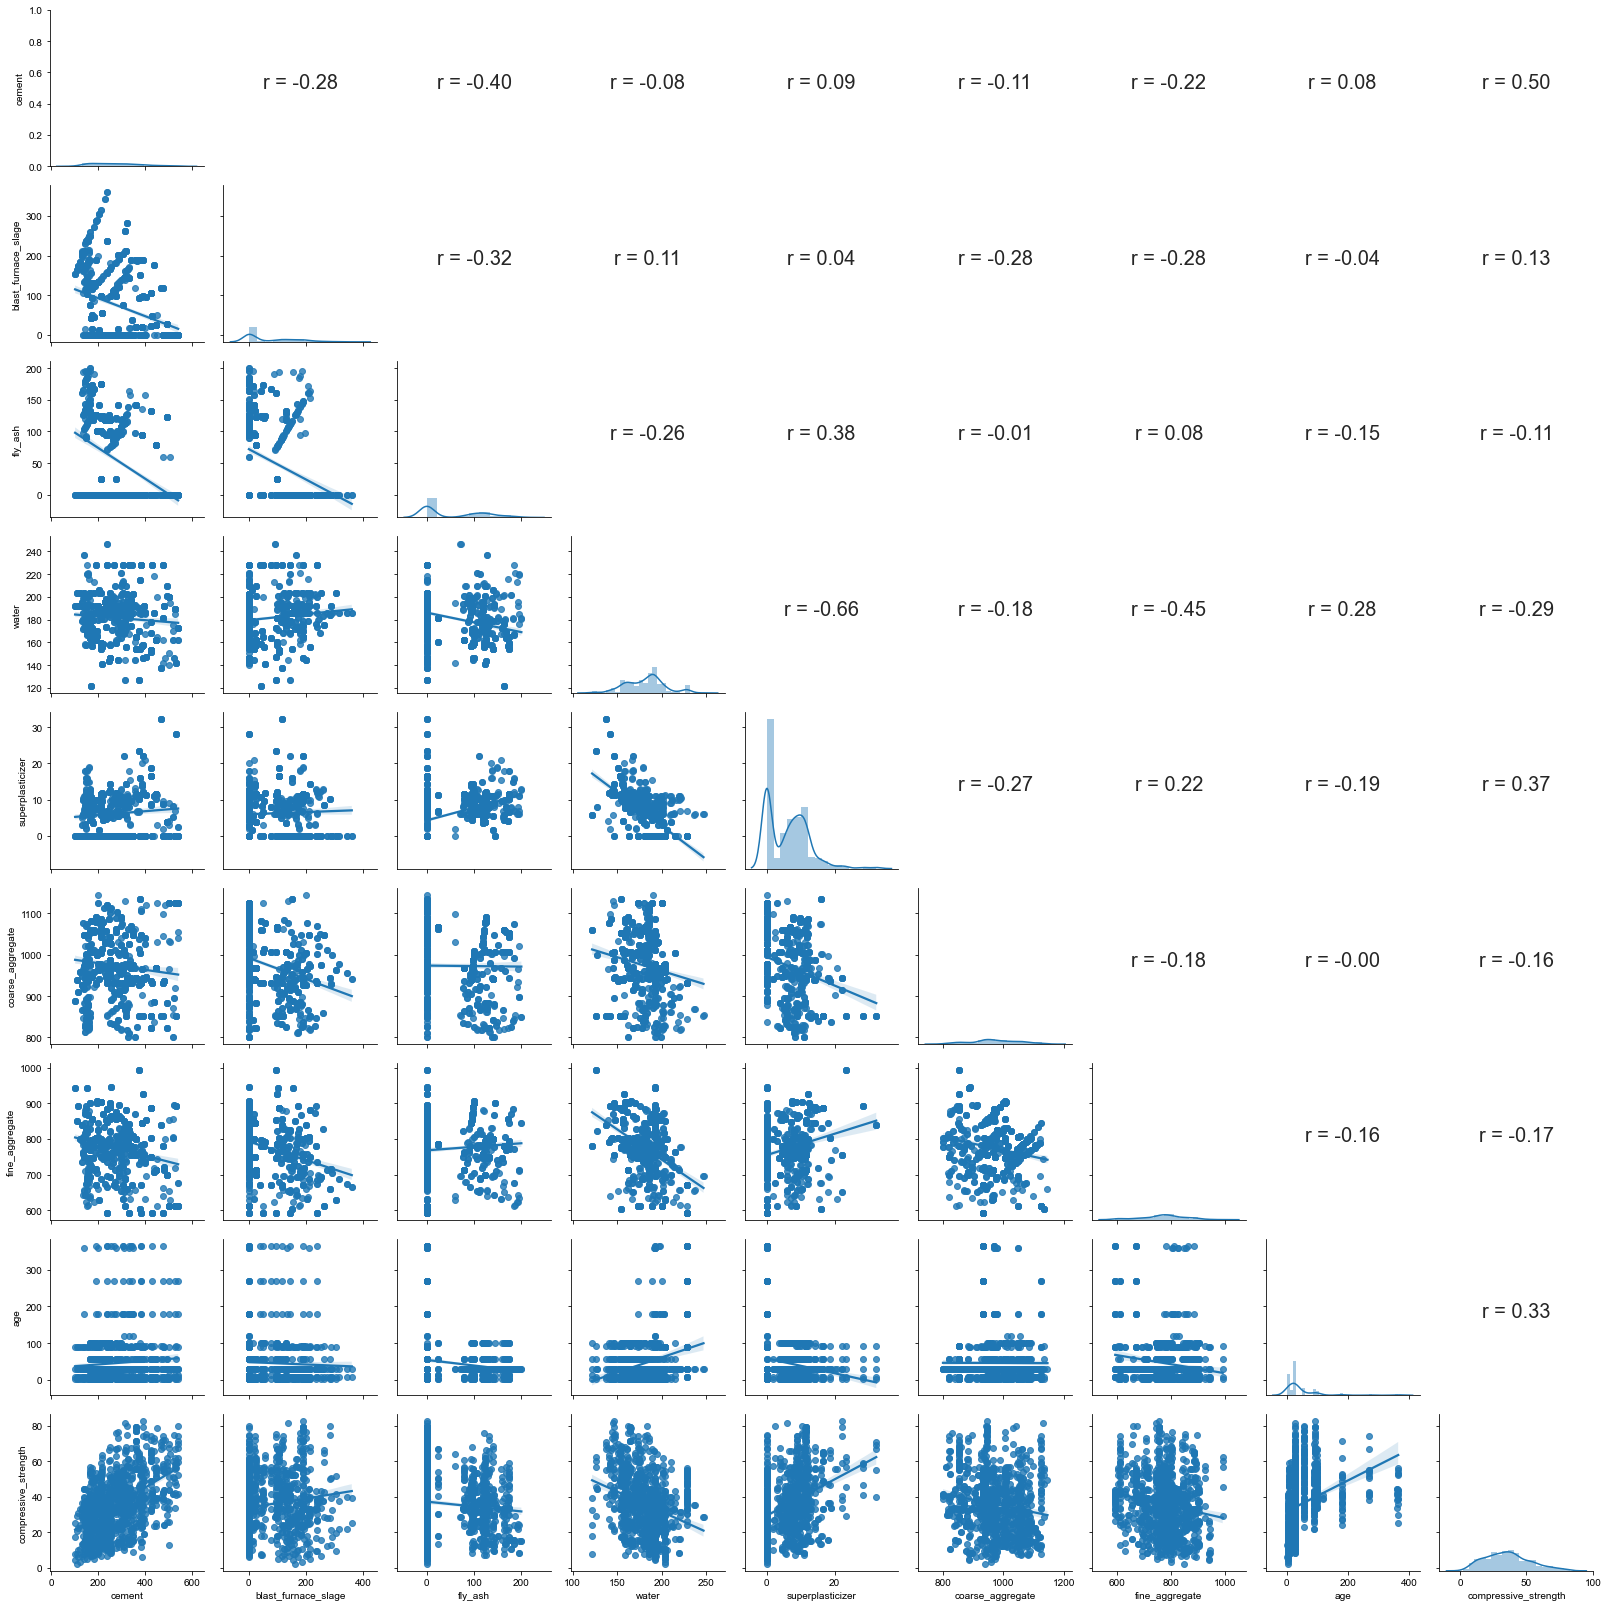

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
def reg_coef(x,y,label=None,color=None,**kwargs):
    sns.set()
    ax = plt.gca()
    r,p = pearsonr(x,y)
   
    ax.annotate('r = {:.2f}'.format(r), xy=(0.5,0.5), xycoords='axes fraction', ha='center',fontsize=20)
    ax.set_xlabel(ax.get_xlabel(), fontsize = 20, rotation = -85,labelpad=25)
    ax.set_ylabel(ax.get_ylabel(), fontsize = 20, rotation = -25,labelpad=105)
    ax.set_axis_off()
   
    


g = sns.PairGrid(real_df)
g.map_diag(sns.distplot)
g.map_lower(sns.regplot)
g.map_upper(reg_coef)

plt.tight_layout()
plt.savefig('static/image/scatter_matrix_sns.png')
plt.show()

In [ ]:
import matplotlib.pyplot as plt

# Create a scatter matrix from the dataframe, color by y_train
scatter_matrix = pd.plotting.scatter_matrix(X, c=y, figsize=(15, 15), marker='*',
                                 hist_kwds={'bins': 15}, s=60, alpha=.8,diagonal='kde',range_padding=0.15)
plt.suptitle('Bivariate Relationships Between Concrete Components',y=0.99,x=0.60,fontsize=30)

for ax in scatter_matrix.ravel():
    ax.set_xlabel(ax.get_xlabel(), fontsize = 20, rotation = -85,labelpad=25)
    ax.set_ylabel(ax.get_ylabel(), fontsize = 20, rotation = -25,labelpad=105)
plt.tight_layout()
plt.savefig('static/image/scatter_matrix_sm.png')
plt.show()